### Imports and data reading - RUN FIRST

In [1]:
import pandas as pd
from visualization import data_visualization, sales_for_top_countries, customer_trend_per_month, top_selling_items
from helpers import read_and_describe
import matplotlib.pyplot as plt
import math 
import warnings        
warnings.filterwarnings("ignore") # ignores warnings

df = read_and_describe('data.csv')

Data types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Numeric data description:

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%    

##### 135080 customerIDs are missing
##### The min and max in Quantity and UnitPrice are alerting - Cleaning is required
##### 1454 missing description

### Data visualization - First look to get more insights

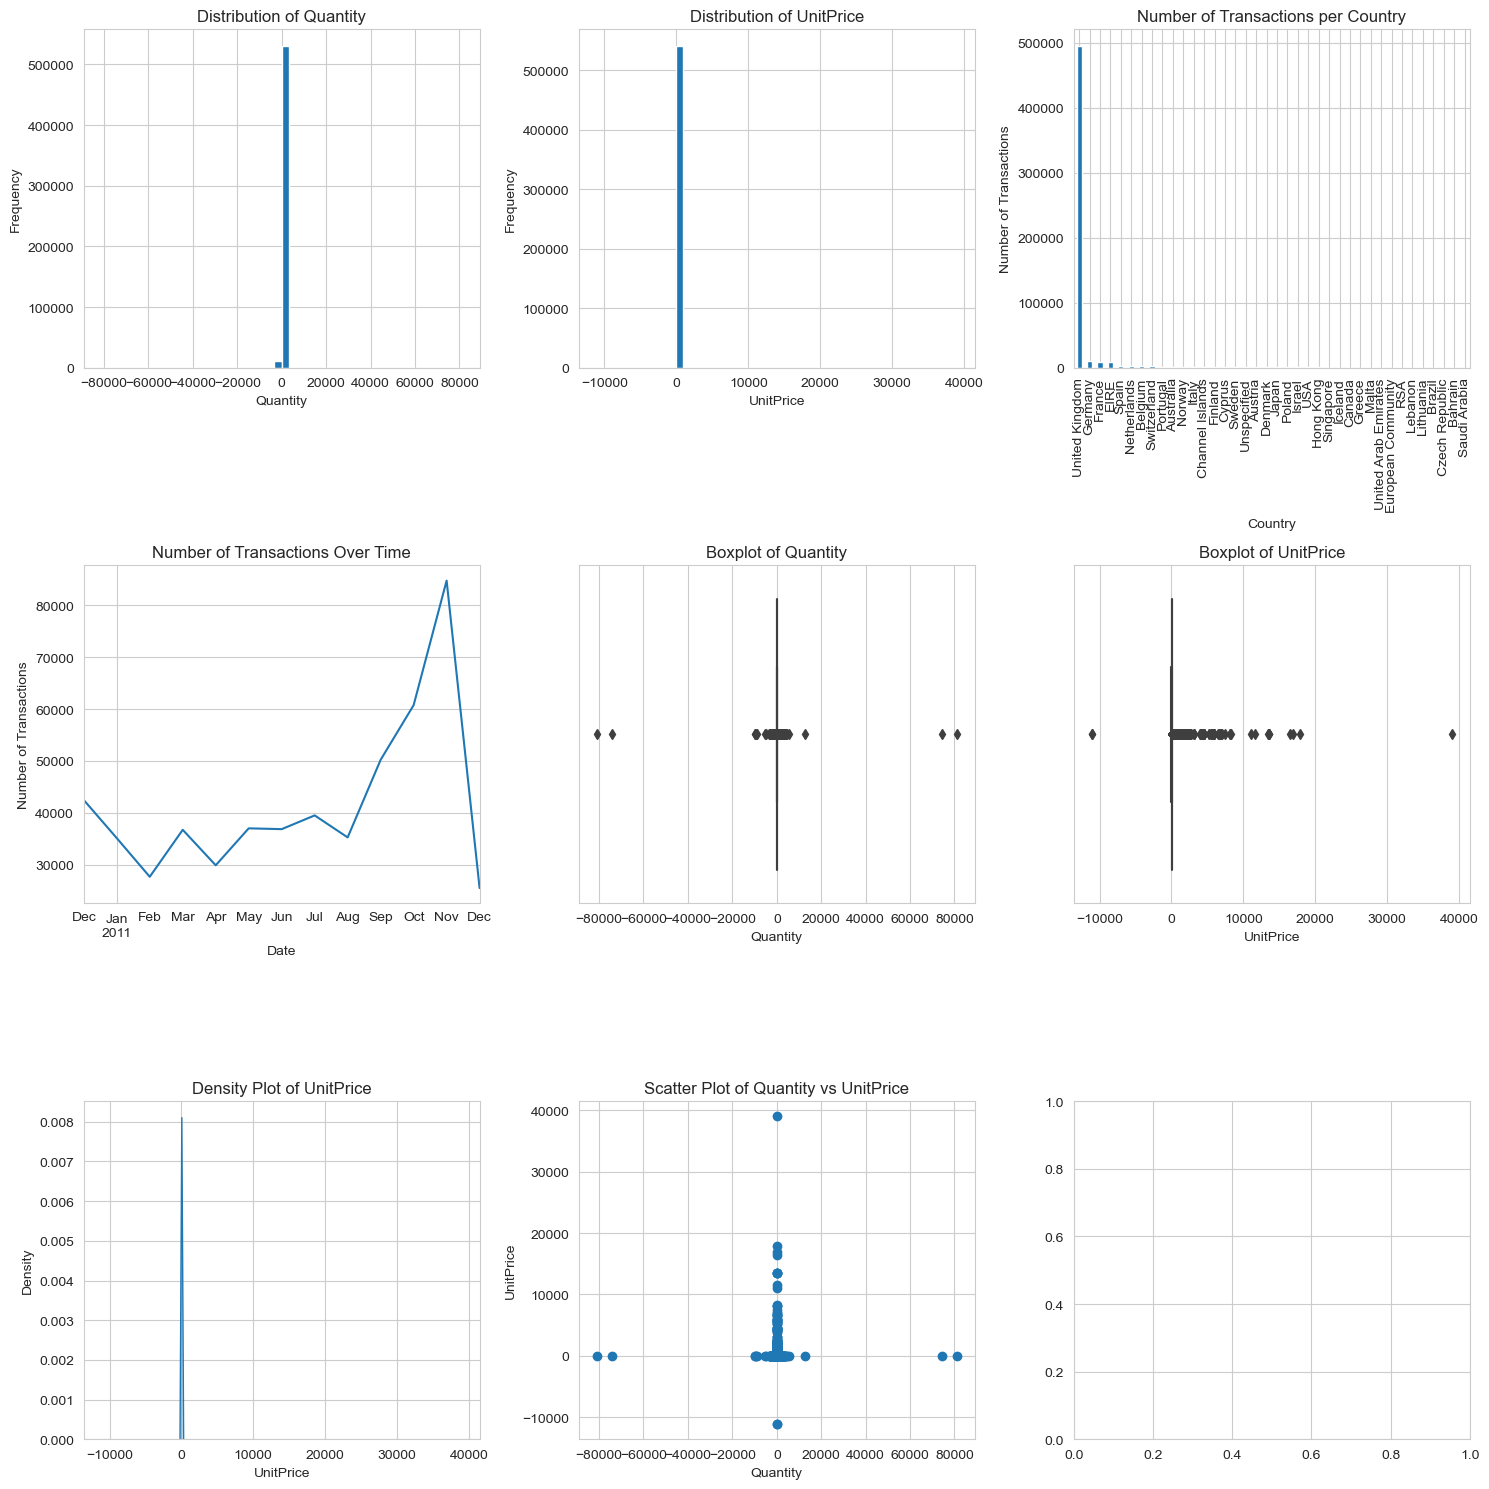

In [2]:
data_visualization(df)

###### - The wide spread observed in the data for both quantity and unit price suggests the presence of outliers, which is further corroborated by the boxplot visualizations.
###### - A significant portion of the data originates from the United Kingdom.
###### - The dataset encompasses transactions spanning from December 2010 to November 2011.

### Cleaning data

#### Part 1: Try handle missing cusomter Ids

In [3]:
# First, sort the DataFrame by InvoiceID and CustomerID
df.sort_values(by=['InvoiceNo', 'CustomerID'], inplace=True)

# Forward fill CustomerID within each InvoiceID group
df['CustomerID'] = df.groupby('InvoiceNo')['CustomerID'].ffill()

# Check the results
print(f'After forward filling: {df["CustomerID"].isna().sum()}\n')

# Fill missing CustomerID values with a specific value 'Unknown'
df['CustomerID'].fillna('UnknownId', inplace=True)

# Check the results
print(f'After Assigning "UnknownId" : {df["CustomerID"].isna().sum()}\n')

After forward filling: 135080

After Assigning "UnknownId" : 0



##### Using InvoiceId didn't help, assigned 'Unknown' to all missing customerIds since the missing data is huge and we can't simply remove it.

#### Part 2: Numerical values cleaning

In [4]:
# List of common missing data indicators 
missing_indicators = ["NA", "Na", "NaN", "na", "N/A", "n/a", "missing", "MISSING", 0]

# Check for any of these indicators in the DataFrame
missing_data = df[df.isin(missing_indicators).any(axis=1)]

# Display the shape of the DataFrame with missing data
missing_data.head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,UnknownId,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,UnknownId,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,UnknownId,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,UnknownId,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,UnknownId,United Kingdom
1988,536550,85044,NaN,1,2010-12-01 14:34:00,0.0,UnknownId,United Kingdom
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.0,UnknownId,United Kingdom
2025,536553,37461,NaN,3,2010-12-01 14:35:00,0.0,UnknownId,United Kingdom
2026,536554,84670,NaN,23,2010-12-01 14:35:00,0.0,UnknownId,United Kingdom
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,UnknownId,United Kingdom


##### 1- Too many unit prices 0 for negative quantites, items without description and "amazon" - could be removed
##### 2- Negative quanities - could be removed

In [5]:
# Cleaning unit prices
prices_less_or_equal_zero = df[df["UnitPrice"] <= 0].shape[0]
print(f'Dropping {prices_less_or_equal_zero} items because they have less or equal zero price')
df = df[df["UnitPrice"] > 0]

# Capping `Quantity` at both ends
quantile_01_quantity = df['Quantity'].quantile(0.01)
quantile_99_quantity = df['Quantity'].quantile(0.99)
df['Quantity'] = df['Quantity'].clip(lower=quantile_01_quantity, upper=quantile_99_quantity)

# Capping `UnitPrice` to remove extreme outliers
quantile_999_unitprice = df['UnitPrice'].quantile(0.999)
df['UnitPrice'] = df['UnitPrice'].clip(lower=0, upper=quantile_999_unitprice)

negative_quantities = (df['Quantity'] < 0).sum()
print(f"\nNumber of negative values in 'Quantity': {negative_quantities}  - Percentage: {round(100*negative_quantities/df.shape[0], 2)}%")

Dropping 2517 items because they have less or equal zero price

Number of negative values in 'Quantity': 9288  - Percentage: 1.72%


In [6]:
df[df["Quantity"] < 1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50000,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65000,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-1,2010-12-01 10:24:00,1.65000,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-1,2010-12-01 10:24:00,0.29000,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-1,2010-12-01 10:24:00,0.29000,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-1,2011-12-09 09:57:00,0.83000,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,206.39218,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-1,2011-12-09 11:57:00,10.95000,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25000,17315.0,United Kingdom


##### We have "Discount" and "Manual" - will be considered in "Description" and "StockCode" cleaning and mapping
##### Negative Quantity could be returned items since it's is very high and there is slight change it's human error - more investigation required

In [7]:
invoices_with_zero_quantities = df[ df["InvoiceNo"].isin(df[df["Quantity"] < 1]["InvoiceNo"])].head(10)
print(invoices_with_zero_quantities[['InvoiceNo','Quantity']])

    InvoiceNo  Quantity
141   C536379        -1
154   C536383        -1
235   C536391        -1
236   C536391        -1
237   C536391        -1
238   C536391        -1
239   C536391        -1
240   C536391        -1
241   C536391        -1
939   C536506        -1


##### The invoices didn't show an added item then removed in the same bill. Dropping all of them
##### Dropping the 'M', 'D', and 'B' as well - Manual, Discount and Bad debit

In [8]:
df = df[df["Quantity"] > 0]
df = df[~df['StockCode'].isin(['M', 'D', 'B'])]

##### Part 3: Stock code and description handling

In [9]:
print(f'Number of unique descriptions {df["Description"].nunique()}')
print(f'Number of unique StockCode {df["StockCode"].nunique()}')
df.groupby("StockCode")["Description"].nunique().sort_values(ascending = False)

Number of unique descriptions 4025
Number of unique StockCode 3920


StockCode
23236     4
23196     4
17107D    3
23244     3
22937     3
         ..
22420     1
22421     1
22422     1
22423     1
m         1
Name: Description, Length: 3920, dtype: int64

In [10]:
# Filter out rows where Description is not missing
non_missing_descriptions = df.dropna(subset=['Description'])

# Create a dictionary mapping StockCode to Description
stockcode_description_mapping = non_missing_descriptions.drop_duplicates(subset='StockCode').set_index('StockCode')['Description'].to_dict()

# Fill missing descriptions in the original dataset
df['Description'] = df.apply(
    lambda row: stockcode_description_mapping[row['StockCode']] if pd.isna(row['Description']) and row['StockCode'] in stockcode_description_mapping else row['Description'],
    axis=1
)

# Dropping 'POSTAGE' products since it's irrelevant
df = df[~df['Description'].isin(['POSTAGE','DOTCOM POSTAGE'])]

df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Data visualization after cleaning

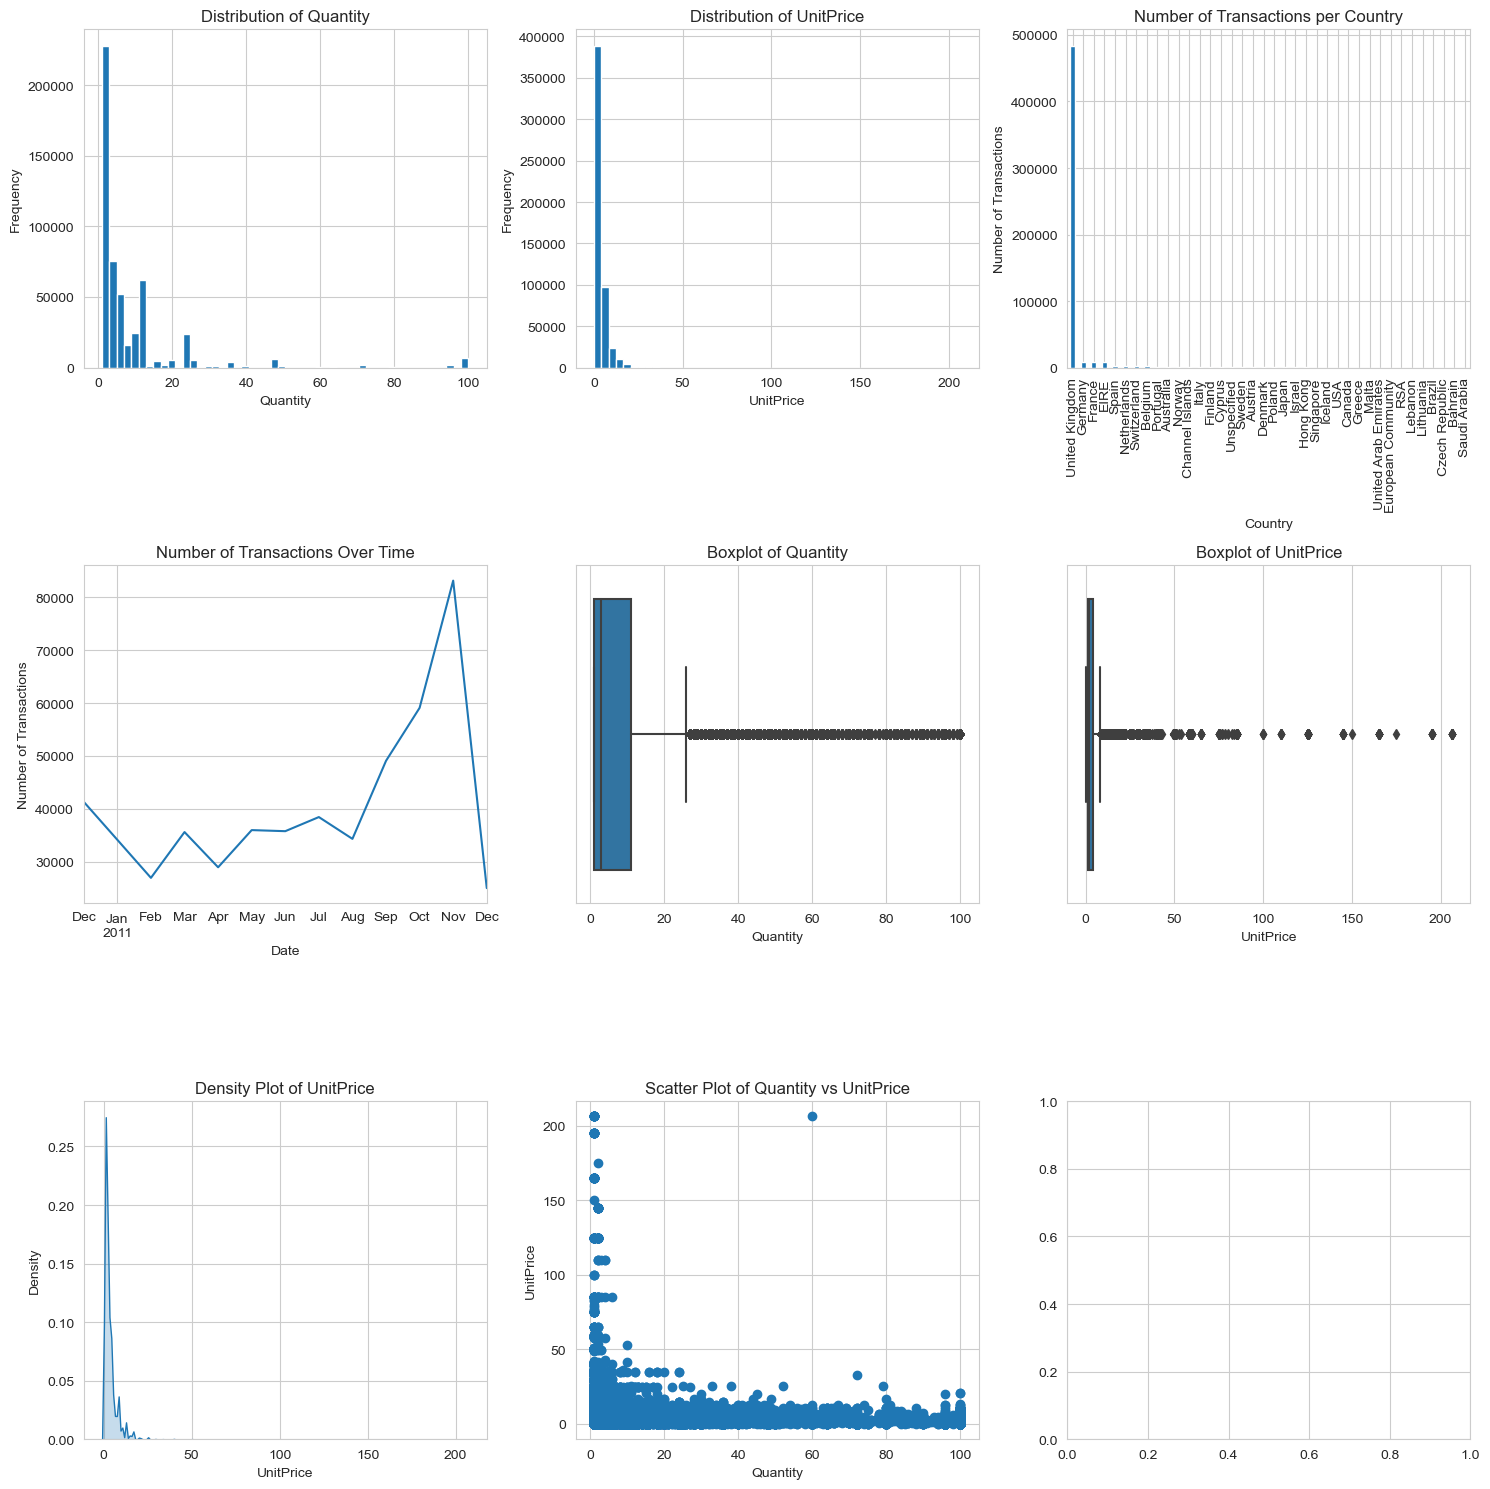

In [11]:
data_visualization(df)

##### We still have outliers but they are reasonable now, most likely because of reatil selling
##### Most of the quantities are between 1-15 
##### Most of the prices are between 0-20
##### The scatter plot shows a very expensive selling (60x220) - most likely a retail stuff

#### Extending data for more analysis

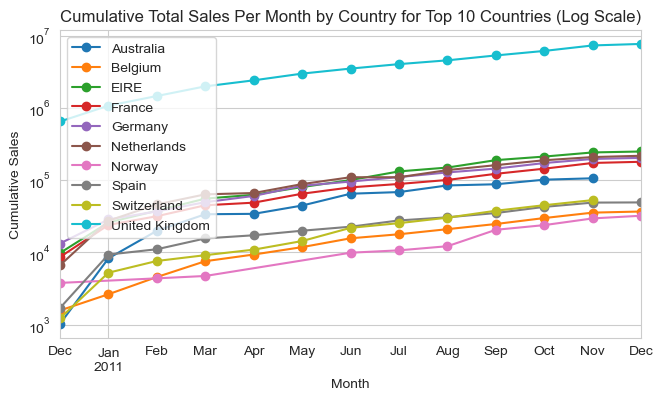

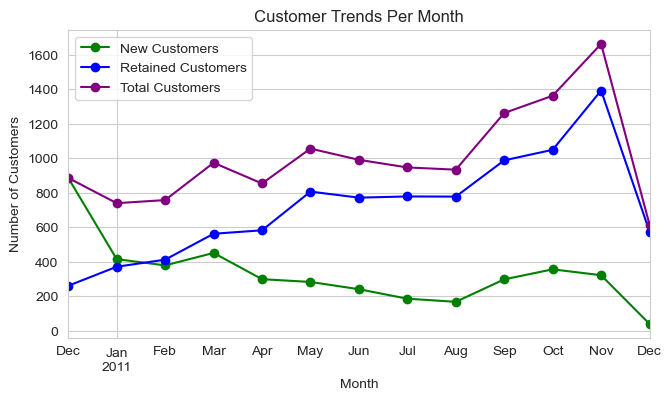

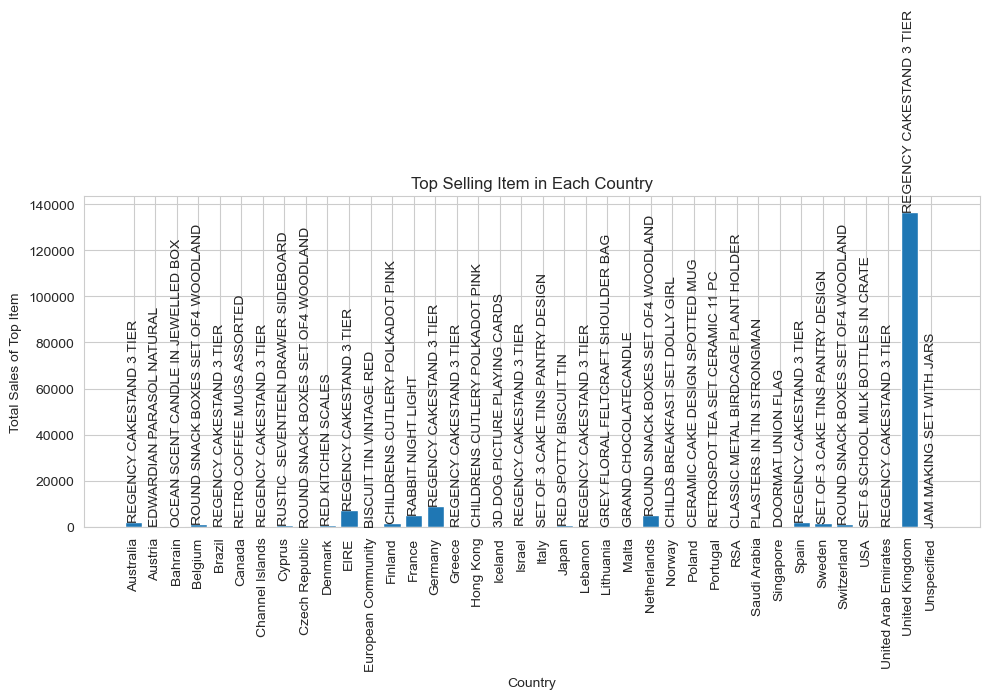

In [12]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
sales_for_top_countries(df)
customer_trend_per_month(df)
top_selling_items(df)

##### - The trend of the sales is increasing in a linear way. These stores are getting successful worldwide.
##### - The number of new customers was increasing first but start decreasing between March and August, then it recovered.
##### - The number of retained customers spiked on august.
##### -'REGENCY CAKESSTAND 3 TIER' is very popular worldwide. Check how it looks here https://www.royalcrownderby.co.uk/product/darley-abbey-pure-gold-three-tier-cake-stand-34cm/

In [13]:
df['Description'].value_counts().head(20)

WHITE HANGING HEART T-LIGHT HOLDER    2323
JUMBO BAG RED RETROSPOT               2112
REGENCY CAKESTAND 3 TIER              2017
PARTY BUNTING                         1706
LUNCH BAG RED RETROSPOT               1594
ASSORTED COLOUR BIRD ORNAMENT         1489
SET OF 3 CAKE TINS PANTRY DESIGN      1399
PACK OF 72 RETROSPOT CAKE CASES       1370
LUNCH BAG  BLACK SKULL.               1328
NATURAL SLATE HEART CHALKBOARD        1263
JUMBO BAG PINK POLKADOT               1238
HEART OF WICKER SMALL                 1226
PAPER CHAIN KIT 50'S CHRISTMAS        1200
JUMBO STORAGE BAG SUKI                1197
JUMBO SHOPPER VINTAGE RED PAISLEY     1190
LUNCH BAG SPACEBOY DESIGN             1179
LUNCH BAG CARS BLUE                   1174
JAM MAKING SET PRINTED                1169
SPOTTY BUNTING                        1158
JAM MAKING SET WITH JARS              1141
Name: Description, dtype: int64

#### Saving cleaned data

In [14]:
df.to_csv('cleaned_data.csv', index=False)